In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import GridSearchCV
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/sboyukliyski/Downloads/Graphviz/bin/'

In [206]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [208]:
def col_to_cat(training_data):
    training_data_copy = training_data.copy()
    for column in training_data_copy:
        if training_data_copy[column].dtype == object:
            integer = 0
            for unique_col in training_data_copy[column].unique():
                integer += 1
                training_data_copy.loc[training_data_copy[column] == unique_col , column] = float(integer)
        else:
            pass
    return training_data_copy

In [209]:
train = pd.read_csv('train.csv')

In [225]:
total_dataset = train
total_dataset_nnull = total_dataset[total_dataset['SalePrice'].notnull()]

## Feature Reduction
Based on domain knowledge it might be worth discussing which parameters I believe might play a large role when pricing real-estate assets.
* Zoning - definitely the function of the building is important for its pricing
* LotArea - the square footage of the property is probably the most important
* LandSlope - important for some technical requirements might increse the price of the propoperty due to geotechnical work
* Neighborhood - definitely a factor, location might increase the value with a 10s of percentage points or more
* House style - refers to number of floors and livable area so probably quite important 
* OverallQual - it can be seen from the data that the quality is proportional to price
* OverallCondition - also very important somewhat related to quality but probably not with a high correlation coefficient 
* YearBuilt - not as important as YearRemodelled
* ExteriorQuality - surprisingly small difference
* BsmtCond - quite a clear trend and also very important in general
* TotalBsmtSF - Total basement square feet very important but probably very highly correlated with square feet of floor 1, floor2 (also correlated but less with square footage of the lot area).
* HeatingQC - obvious trend
* CentralAir - good feature to have but less important
* Electrical - good feature to have but less important no data for some electric systems
* 1stFlrSF - high correlation to basement SF and 2nd SF but still good to have (PCA might deal with this issue)
* 2ndFlrSF - high correlation to basement SF and 1st SF but still good to have (PCA might deal with this issue)
* GrLivArea - good feature to have, need to check correlations
* FullBath - shows a decent linear trend
* TotRmsAbvGrd - Important and has a clear linear trend
* GarageYrBlt - Probably high correlation with year of construction of the house
* GarageCars - Number of cars to fit in the garage high correlation with area
* GarageArea - Probably not as big of a factor as the actual number of cars that can fit into the garage
* GarageQual - Less of an interest to potential buyers, probably only poor quality results in lower price
* WoodDeckSF - good additional feature, probably not highly correlated with other parameters, linited trend noticed
* OpenPorchSF - good feature not correlated with previous ones, noticed 
* EnclosedPorch - leave it in, even though not a major factor

In [303]:
features_selected_dataset = total_dataset_nnull[['Id','MSSubClass', 'MSZoning' , 'LotFrontage', 'LotArea', 
     'LandSlope', 'Neighborhood', 'HouseStyle', 'OverallQual', 
     'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st',
     'ExterCond', 'Foundation', 'BsmtCond', 'TotalBsmtSF', 
     'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
     'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
     'GarageArea', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice']]

features_selected_dataset

Id  MSSubClass MSZoning  LotFrontage  LotArea LandSlope Neighborhood  \
0        1          60       RL         65.0     8450       Gtl      CollgCr   
1        2          20       RL         80.0     9600       Gtl      Veenker   
2        3          60       RL         68.0    11250       Gtl      CollgCr   
3        4          70       RL         60.0     9550       Gtl      Crawfor   
4        5          60       RL         84.0    14260       Gtl      NoRidge   
...    ...         ...      ...          ...      ...       ...          ...   
1455  1456          60       RL         62.0     7917       Gtl      Gilbert   
1456  1457          20       RL         85.0    13175       Gtl       NWAmes   
1457  1458          70       RL         66.0     9042       Gtl      Crawfor   
1458  1459          20       RL         68.0     9717       Gtl        NAmes   
1459  1460          20       RL         75.0     9937       Gtl      Edwards   

     HouseStyle  OverallQual  OverallCond  ...  FullBath  TotRmsAbvGrd  \
0        2Story            7            5  ...         2             8   
1        1Story            6            8  ...         2             6   
2        2Story            7            5  ...         2             6   
3        2Story            7            5  ...         1             7   
4        2Story            8            5  ...         2             9   
...         ...          ...          ...  ...       ...           ...   
1455     2Story            6            5  ...         2             7   
1456     1Story            6            6  ...         2             7   
1457     2Story            7            9  ...         2             9   
1458     1Story            5            6  ...         1             5   
1459     1Story            5            6  ...         1             6   

     GarageYrBlt GarageCars GarageArea GarageQual  WoodDeckSF OpenPorchSF  \
0         2003.0          2        548         TA           0          61   
1         1976.0          2        460         TA         298           0   
2         2001.0          2        608         TA           0          42   
3         1998.0          3        642         TA           0          35   
4         2000.0          3        836         TA         192          84   
...          ...        ...        ...        ...         ...         ...   
1455      1999.0          2        460         TA           0          40   
1456      1978.0          2        500         TA         349           0   
1457      1941.0          1        252         TA           0          60   
1458      1950.0          1        240         TA         366           0   
1459      1965.0          1        276         TA         736          68   

     EnclosedPorch SalePrice  
0                0    208500  
1                0    181500  
2                0    223500  
3              272    140000  
4                0    250000  
...            ...       ...  
1455             0    175000  
1456             0    210000  
1457             0    266500  
1458           112    142125  
1459             0    147500  

[1460 rows x 33 columns]

In [304]:
def MSE(Y_pred, Y_test):
    return np.sum((Y_test-Y_pred)**2)/len(Y_test)

In [305]:
def train_xgboost(dataset, num_round = 100):
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=25)
    train_data = col_to_cat(train_data)
    
    X_train, Y_train, id_train = train_data.drop('SalePrice', axis = 1).fillna(0), train_data['SalePrice'].to_numpy('float32'), train_data['Id']
    X_val, Y_val, id_val = val_data.drop('SalePrice', axis = 1).fillna(0), val_data['SalePrice'].to_numpy('float32'), val_data['Id']
    
    
    X_train = col_to_cat(X_train).drop('Id', axis =1).astype('float32')
    X_val = col_to_cat(X_val).drop('Id', axis =1).astype('float32')
    
    dtrain = xgb.DMatrix(data=X_train,label=Y_train, missing=np.NaN)
    dval = xgb.DMatrix(data=X_val,label=Y_val, missing=np.NaN)
    
    param = {'objective': 'reg:linear'}
    
    evallist = [(dval, 'eval'), (dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist)
    ypred = pd.DataFrame(bst.predict(dval), columns = ['SalePrice'])
    ypred['Id'] = id_val.values
    return bst, ypred

In [306]:
bst, y_pred = train_xgboost(features_selected_dataset, num_round = 1000)

[17:23:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-rmse:154097.92756	train-rmse:139748.77281
[1]	eval-rmse:116752.34525	train-rmse:100860.33813
[2]	eval-rmse:90721.85195	train-rmse:73622.78630
[3]	eval-rmse:72554.17893	train-rmse:54557.89299
[4]	eval-rmse:60657.56574	train-rmse:41326.50795
[5]	eval-rmse:52484.67883	train-rmse:32158.63023
[6]	eval-rmse:46834.88309	train-rmse:25780.16686
[7]	eval-rmse:42771.83950	train-rmse:21413.55277
[8]	eval-rmse:40624.19829	train-rmse:18438.34162
[9]	eval-rmse:38595.75548	train-rmse:16143.14453
[10]	eval-rmse:37309.05753	train-rmse:14796.10821
[11]	eval-rmse:36185.04835	train-rmse:13742.41321
[12]	eval-rmse:35399.99757	train-rmse:12964.66969
[13]	eval-rmse:34702.67360	train-rmse:12418.24794
[14]	eval-rmse:34146.93352	train-rmse:11914.58097
[15]	eval-rmse:33847.05933	train-rmse:11554.63065
[16]	eval-rmse:33632.29172	tr

C:\Users\sboyukliyski\Anaconda3\envs\tf\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[57]	eval-rmse:33438.97938	train-rmse:3952.84167
[58]	eval-rmse:33480.94343	train-rmse:3822.80187
[59]	eval-rmse:33441.41602	train-rmse:3652.55899
[60]	eval-rmse:33455.24524	train-rmse:3555.35292
[61]	eval-rmse:33464.18876	train-rmse:3500.39200
[62]	eval-rmse:33453.07959	train-rmse:3456.14588
[63]	eval-rmse:33453.03374	train-rmse:3353.25876
[64]	eval-rmse:33440.08316	train-rmse:3289.51803
[65]	eval-rmse:33436.98499	train-rmse:3192.95107
[66]	eval-rmse:33431.24388	train-rmse:3073.70187
[67]	eval-rmse:33441.15330	train-rmse:2979.69012
[68]	eval-rmse:33469.80518	train-rmse:2903.66670
[69]	eval-rmse:33484.74570	train-rmse:2797.99943
[70]	eval-rmse:33501.70661	train-rmse:2759.49101
[71]	eval-rmse:33522.72391	train-rmse:2671.02056
[72]	eval-rmse:33501.22815	train-rmse:2630.25903
[73]	eval-rmse:33466.71099	train-rmse:2560.67245
[74]	eval-rmse:33478.72917	train-rmse:2458.33984
[75]	eval-rmse:33479.87510	train-rmse:2377.20875
[76]	eval-rmse:33482.79519	train-rmse:2307.69534
[77]	eval-rmse:33459

[224]	eval-rmse:33402.18474	train-rmse:261.35599
[225]	eval-rmse:33402.36514	train-rmse:259.41211
[226]	eval-rmse:33402.44844	train-rmse:258.37635
[227]	eval-rmse:33403.32918	train-rmse:257.60237
[228]	eval-rmse:33402.75529	train-rmse:256.70421
[229]	eval-rmse:33402.45542	train-rmse:255.06116
[230]	eval-rmse:33402.80994	train-rmse:253.72844
[231]	eval-rmse:33402.49422	train-rmse:253.24715
[232]	eval-rmse:33401.83708	train-rmse:252.78515
[233]	eval-rmse:33402.09984	train-rmse:252.37015
[234]	eval-rmse:33402.19794	train-rmse:251.60020
[235]	eval-rmse:33402.25611	train-rmse:251.29687
[236]	eval-rmse:33402.94935	train-rmse:249.91734
[237]	eval-rmse:33402.95083	train-rmse:249.77213
[238]	eval-rmse:33403.21787	train-rmse:249.40406
[239]	eval-rmse:33403.24795	train-rmse:248.67632
[240]	eval-rmse:33403.32335	train-rmse:248.43107
[241]	eval-rmse:33402.94785	train-rmse:247.51844
[242]	eval-rmse:33403.21739	train-rmse:246.81365
[243]	eval-rmse:33403.18088	train-rmse:245.98114
[244]	eval-rmse:3340

[392]	eval-rmse:33406.35652	train-rmse:231.51689
[393]	eval-rmse:33406.39872	train-rmse:231.51190
[394]	eval-rmse:33406.40041	train-rmse:231.51084
[395]	eval-rmse:33406.41855	train-rmse:231.50891
[396]	eval-rmse:33406.41341	train-rmse:231.50477
[397]	eval-rmse:33406.38302	train-rmse:231.50109
[398]	eval-rmse:33406.35128	train-rmse:231.49905
[399]	eval-rmse:33406.35876	train-rmse:231.49792
[400]	eval-rmse:33406.40293	train-rmse:231.49549
[401]	eval-rmse:33406.41327	train-rmse:231.49484
[402]	eval-rmse:33406.45962	train-rmse:231.49161
[403]	eval-rmse:33406.47731	train-rmse:231.49061
[404]	eval-rmse:33406.48275	train-rmse:231.48963
[405]	eval-rmse:33406.48845	train-rmse:231.48897
[406]	eval-rmse:33406.49797	train-rmse:231.48870
[407]	eval-rmse:33406.49898	train-rmse:231.48755
[408]	eval-rmse:33406.51543	train-rmse:231.48691
[409]	eval-rmse:33406.49566	train-rmse:231.48615
[410]	eval-rmse:33406.49479	train-rmse:231.48489
[411]	eval-rmse:33406.50047	train-rmse:231.48392
[412]	eval-rmse:3340

[560]	eval-rmse:33406.55210	train-rmse:231.45254
[561]	eval-rmse:33406.55055	train-rmse:231.45253
[562]	eval-rmse:33406.55309	train-rmse:231.45253
[563]	eval-rmse:33406.55344	train-rmse:231.45252
[564]	eval-rmse:33406.55430	train-rmse:231.45252
[565]	eval-rmse:33406.55405	train-rmse:231.45251
[566]	eval-rmse:33406.55189	train-rmse:231.45250
[567]	eval-rmse:33406.55332	train-rmse:231.45249
[568]	eval-rmse:33406.55380	train-rmse:231.45249
[569]	eval-rmse:33406.55429	train-rmse:231.45249
[570]	eval-rmse:33406.55366	train-rmse:231.45248
[571]	eval-rmse:33406.55230	train-rmse:231.45248
[572]	eval-rmse:33406.55191	train-rmse:231.45248
[573]	eval-rmse:33406.55178	train-rmse:231.45247
[574]	eval-rmse:33406.55167	train-rmse:231.45247
[575]	eval-rmse:33406.55110	train-rmse:231.45247
[576]	eval-rmse:33406.55000	train-rmse:231.45247
[577]	eval-rmse:33406.54889	train-rmse:231.45246
[578]	eval-rmse:33406.54841	train-rmse:231.45246
[579]	eval-rmse:33406.54832	train-rmse:231.45246
[580]	eval-rmse:3340

[728]	eval-rmse:33406.55309	train-rmse:231.45239
[729]	eval-rmse:33406.55311	train-rmse:231.45239
[730]	eval-rmse:33406.55312	train-rmse:231.45239
[731]	eval-rmse:33406.55313	train-rmse:231.45239
[732]	eval-rmse:33406.55314	train-rmse:231.45239
[733]	eval-rmse:33406.55316	train-rmse:231.45239
[734]	eval-rmse:33406.55317	train-rmse:231.45239
[735]	eval-rmse:33406.55318	train-rmse:231.45239
[736]	eval-rmse:33406.55319	train-rmse:231.45239
[737]	eval-rmse:33406.55320	train-rmse:231.45239
[738]	eval-rmse:33406.55322	train-rmse:231.45239
[739]	eval-rmse:33406.55323	train-rmse:231.45239
[740]	eval-rmse:33406.55324	train-rmse:231.45239
[741]	eval-rmse:33406.55325	train-rmse:231.45239
[742]	eval-rmse:33406.55326	train-rmse:231.45239
[743]	eval-rmse:33406.55328	train-rmse:231.45239
[744]	eval-rmse:33406.55329	train-rmse:231.45239
[745]	eval-rmse:33406.55330	train-rmse:231.45239
[746]	eval-rmse:33406.55331	train-rmse:231.45239
[747]	eval-rmse:33406.55332	train-rmse:231.45239
[748]	eval-rmse:3340

[896]	eval-rmse:33406.55512	train-rmse:231.45239
[897]	eval-rmse:33406.55513	train-rmse:231.45239
[898]	eval-rmse:33406.55515	train-rmse:231.45239
[899]	eval-rmse:33406.55516	train-rmse:231.45239
[900]	eval-rmse:33406.55517	train-rmse:231.45239
[901]	eval-rmse:33406.55518	train-rmse:231.45239
[902]	eval-rmse:33406.55519	train-rmse:231.45239
[903]	eval-rmse:33406.55521	train-rmse:231.45239
[904]	eval-rmse:33406.55522	train-rmse:231.45239
[905]	eval-rmse:33406.55523	train-rmse:231.45239
[906]	eval-rmse:33406.55524	train-rmse:231.45239
[907]	eval-rmse:33406.55525	train-rmse:231.45239
[908]	eval-rmse:33406.55527	train-rmse:231.45239
[909]	eval-rmse:33406.55528	train-rmse:231.45239
[910]	eval-rmse:33406.55529	train-rmse:231.45239
[911]	eval-rmse:33406.55530	train-rmse:231.45239
[912]	eval-rmse:33406.55532	train-rmse:231.45239
[913]	eval-rmse:33406.55533	train-rmse:231.45239
[914]	eval-rmse:33406.55534	train-rmse:231.45239
[915]	eval-rmse:33406.55535	train-rmse:231.45239
[916]	eval-rmse:3340

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

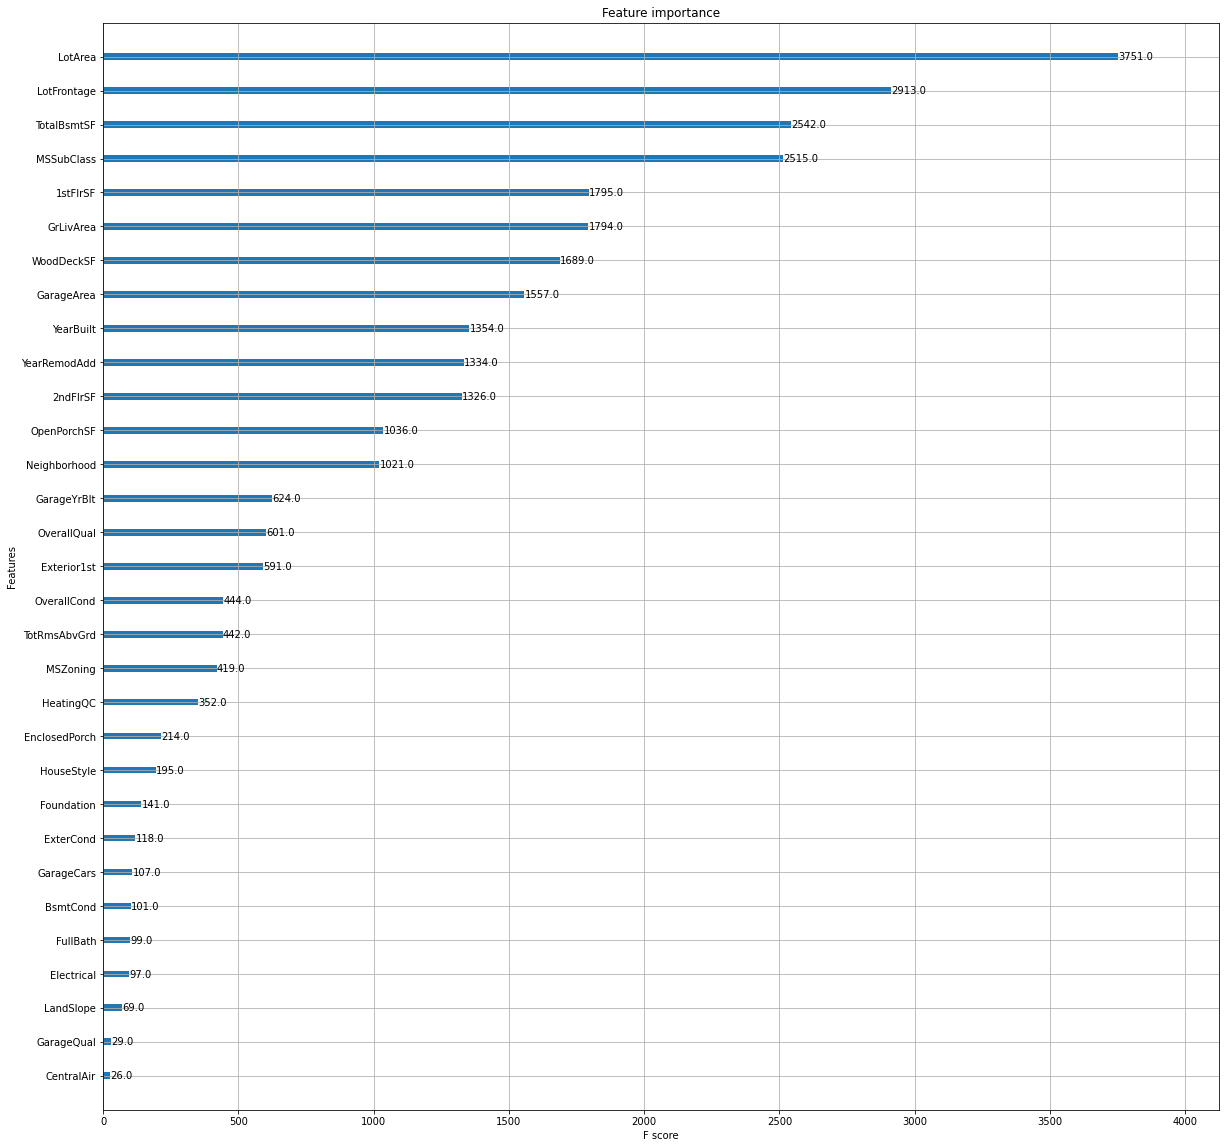

In [307]:
fig, ax = plt.subplots(figsize = (20,20))
xgb.plot_importance(bst, ax = ax)

<AxesSubplot:>

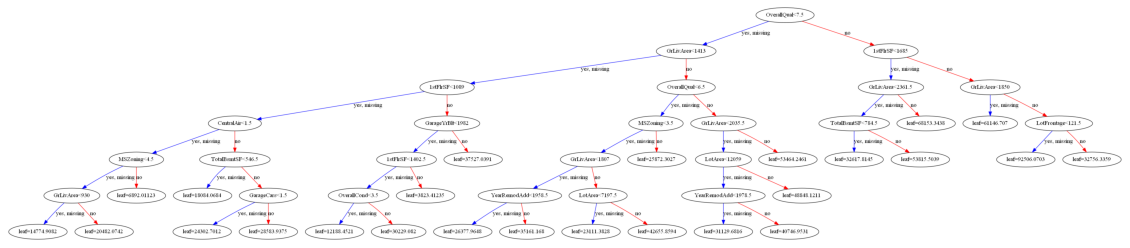

In [308]:
fig, ax = plt.subplots(figsize = (20,10))
xgb.plot_tree(bst, num_trees=1, ax = ax)

In [309]:
test = pd.read_csv('test.csv')
test = test[['Id','MSSubClass', 'MSZoning' , 'LotFrontage', 'LotArea', 
     'LandSlope', 'Neighborhood', 'HouseStyle', 'OverallQual', 
     'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st',
     'ExterCond', 'Foundation', 'BsmtCond', 'TotalBsmtSF', 
     'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
     'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
     'GarageArea', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']]

test = col_to_cat(test)
X, id_t = test.drop('Id', axis = 1).fillna(0), test['Id']
dtotal= xgb.DMatrix(data=X, missing=np.NaN)

In [310]:
ypred = pd.DataFrame(bst.predict(dtotal), columns = ['SalePrice'])
ypred['Id'] = id_t

In [311]:
ypred.set_index('Id').to_csv('model.csv')

In [312]:
ypred.set_index('Id')

SalePrice
Id                 
1461   95054.390625
1462  160916.859375
1463  155402.062500
1464  178534.140625
1465  193428.750000
...             ...
2915   84736.265625
2916   82098.523438
2917  191212.343750
2918  102622.250000
2919  248906.062500

[1459 rows x 1 columns]